In [1]:
import pandas as pd
import numpy as np

In [2]:
movie_data = pd.read_csv('movie_data.csv')

In [6]:
movie_data.head(10)

,Title,Synopsis
0,The Godfather,"In late summer 1945, guests are gathered for t..."
1,The Shawshank Redemption,"In 1947, Andy Dufresne (Tim Robbins), a banker..."
2,Schindler's List,The relocation of Polish Jews from surrounding...
3,Raging Bull,"The film opens in 1964, where an older and fat..."
4,Casablanca,"In the early years of World War II, December 1..."
5,One Flew Over the Cuckoo's Nest,"In 1963 Oregon, Randle Patrick McMurphy (Nicho..."
6,Gone with the Wind,"The film opens in Tara, a cotton plantation ow..."
7,Citizen Kane,"It's 1941, and newspaper tycoon Charles Foster..."
8,The Wizard of Oz,Dorothy Gale (Judy Garland) is an orphaned tee...
9,Titanic,"In 1996, treasure hunter Brock Lovett and his ..."


In [7]:
movie_titles = movie_data['Title'].tolist()
movie_synopses = movie_data['Synopsis'].tolist()

print ("Movie:", movie_titles[0])
print ("Movie Synopsis:", movie_synopses[0][:1000])

Movie: The Godfather
Movie Synopsis: In late summer 1945, guests are gathered for the wedding reception of Don Vito Corleone's daughter Connie (Talia Shire) and Carlo Rizzi (Gianni Russo). Vito (Marlon Brando), the head of the Corleone Mafia family, is known to friends and associates as "Godfather." He and Tom Hagen (Robert Duvall), the Corleone family lawyer, are hearing requests for favors because, according to Italian tradition, "no Sicilian can refuse a request on his daughter's wedding day." One of the men who asks the Don for a favor is Amerigo Bonasera, a successful mortician and acquaintance of the Don, whose daughter was brutally beaten by two young men because she refused their advances; the men received minimal punishment. The Don is disappointed in Bonasera, who'd avoided most contact with the Don due to Corleone's nefarious business dealings. The Don's wife is godmother to Bonasera's shamed daughter, a relationship the Don uses to extract new loyalty from the undertaker. T

In [9]:
from normalization import normalize_corpus
from utils import build_feature_matrix

In [10]:
# normalize corpus
import nltk
nltk.download('punkt')
norm_movie_synopses = normalize_corpus(movie_synopses,
                                       lemmatize=True,
                                       only_text_chars=True)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [11]:
# extract tf-idf features
vectorizer, feature_matrix = build_feature_matrix(norm_movie_synopses,
                                                  feature_type='tfidf',
                                                  min_df=0.24, max_df=0.85,
                                                  ngram_range=(1, 2))

In [13]:
# view number of features
print (feature_matrix.shape)

(100, 307)


In [14]:
# get feature names
feature_names = vectorizer.get_feature_names()

In [15]:
# print sample features
print (feature_names[:20])

['able', 'accept', 'across', 'act', 'agree', 'alive', 'allow', 'alone', 'along', 'already', 'although', 'always', 'another', 'anything', 'apartment', 'appear', 'approach', 'arm', 'army', 'around']


In [16]:
from sklearn.cluster import KMeans

def k_means(feature_matrix, num_clusters=5):
    km = KMeans(n_clusters=num_clusters,
                max_iter=10000)
    km.fit(feature_matrix)
    clusters = km.labels_
    return km, clusters

num_clusters = 5    
km_obj, clusters = k_means(feature_matrix=feature_matrix,
                           num_clusters=num_clusters)
movie_data['Cluster'] = clusters


In [17]:
from collections import Counter
# get the total number of movies per cluster
c = Counter(clusters)
print (c.items())

dict_items([(4, 19), (1, 27), (0, 19), (3, 17), (2, 18)])


In [18]:
def get_cluster_data(clustering_obj, movie_data, 
                     feature_names, num_clusters,
                     topn_features=10):

    cluster_details = {}  
    # get cluster centroids
    ordered_centroids = clustering_obj.cluster_centers_.argsort()[:, ::-1]
    # get key features for each cluster
    # get movies belonging to each cluster
    for cluster_num in range(num_clusters):
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster_num'] = cluster_num
        key_features = [feature_names[index] 
                        for index 
                        in ordered_centroids[cluster_num, :topn_features]]
        cluster_details[cluster_num]['key_features'] = key_features
        
        movies = movie_data[movie_data['Cluster'] == cluster_num]['Title'].values.tolist()
        cluster_details[cluster_num]['movies'] = movies
    
    return cluster_details


In [20]:
def print_cluster_data(cluster_data):
    # print cluster details
    for cluster_num, cluster_details in cluster_data.items():
        print ("Cluster {} details:".format(cluster_num))
        print ("-"*20)
        print ("Key features:", cluster_details['key_features'])
        print ("Movies in this cluster:")
        print (", ".join(cluster_details['movies']))
        print ("="*40)

In [21]:
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity
import random
from matplotlib.font_manager import FontProperties

def plot_clusters(num_clusters, feature_matrix,
                  cluster_data, movie_data,
                  plot_size=(16,8)):
    # generate random color for clusters                  
    def generate_random_color():
        color = '#%06x' % random.randint(0, 0xFFFFFF)
        return color
    # define markers for clusters    
    markers = ['o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd']
    # build cosine distance matrix
    cosine_distance = 1 - cosine_similarity(feature_matrix) 
    # dimensionality reduction using MDS
    mds = MDS(n_components=2, dissimilarity="precomputed", 
              random_state=1)
    # get coordinates of clusters in new low-dimensional space
    plot_positions = mds.fit_transform(cosine_distance)  
    x_pos, y_pos = plot_positions[:, 0], plot_positions[:, 1]
    # build cluster plotting data
    cluster_color_map = {}
    cluster_name_map = {}
    for cluster_num, cluster_details in cluster_data.items():
        # assign cluster features to unique label
        cluster_color_map[cluster_num] = generate_random_color()
        cluster_name_map[cluster_num] = ', '.join(cluster_details['key_features'][:5]).strip()
    # map each unique cluster label with its coordinates and movies
    cluster_plot_frame = pd.DataFrame({'x': x_pos,
                                       'y': y_pos,
                                       'label': movie_data['Cluster'].values.tolist(),
                                       'title': movie_data['Title'].values.tolist()
                                        })
    grouped_plot_frame = cluster_plot_frame.groupby('label')
    # set plot figure size and axes
    fig, ax = plt.subplots(figsize=plot_size) 
    ax.margins(0.05)
    # plot each cluster using co-ordinates and movie titles
    for cluster_num, cluster_frame in grouped_plot_frame:
         marker = markers[cluster_num] if cluster_num < len(markers) \
                  else np.random.choice(markers, size=1)[0]
         ax.plot(cluster_frame['x'], cluster_frame['y'], 
                 marker=marker, linestyle='', ms=12,
                 label=cluster_name_map[cluster_num], 
                 color=cluster_color_map[cluster_num], mec='none')
         ax.set_aspect('auto')
         ax.tick_params(axis= 'x', which='both', bottom='off', top='off',        
                        labelbottom='off')
         ax.tick_params(axis= 'y', which='both', left='off', top='off',         
                        labelleft='off')
    fontP = FontProperties()
    fontP.set_size('small')    
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.01), fancybox=True, 
              shadow=True, ncol=5, numpoints=1, prop=fontP) 
    #add labels as the film titles
    for index in range(len(cluster_plot_frame)):
        ax.text(cluster_plot_frame.ix[index]['x'], 
                cluster_plot_frame.ix[index]['y'], 
                cluster_plot_frame.ix[index]['title'], size=8)  
    # show the plot           
    plt.show() 

In [22]:
cluster_data =  get_cluster_data(clustering_obj=km_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=num_clusters,
                                 topn_features=5)         

print_cluster_data(cluster_data) 

Cluster 0 details:
--------------------
Key features: ['soldier', 'army', 'war', 'kill', 'officer']
Movies in this cluster:
Schindler's List, Gone with the Wind, The Bridge on the River Kwai, Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb, Apocalypse Now, The Lord of the Rings: The Return of the King, Gladiator, From Here to Eternity, Saving Private Ryan, A Streetcar Named Desire, The Best Years of Our Lives, Ben-Hur, Patton, The Good, the Bad and the Ugly, Platoon, Dances with Wolves, The Pianist, All Quiet on the Western Front, Network
Cluster 1 details:
--------------------
Key features: ['kill', 'man', 'water', 'shoot', 'men']
Movies in this cluster:
The Shawshank Redemption, The Wizard of Oz, Lawrence of Arabia, On the Waterfront, Star Wars, The Silence of the Lambs, Chinatown, It's a Wonderful Life, Some Like It Hot, Gandhi, Unforgiven, Raiders of the Lost Ark, Jaws, Butch Cassidy and the Sundance Kid, The Treasure of the Sierra Madre, High Noon, Goodfellas,

C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:59: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


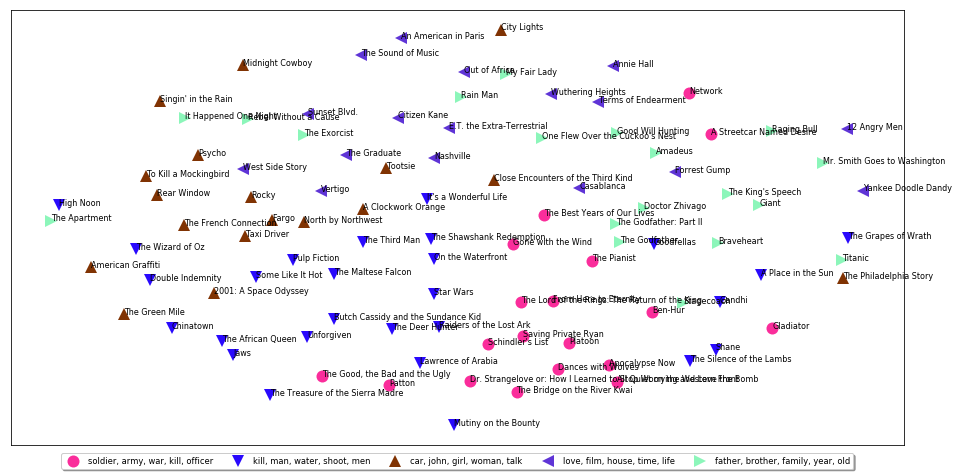

In [23]:
plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=movie_data,
              plot_size=(16,8))     

In [24]:
from sklearn.cluster import AffinityPropagation
              
def affinity_propagation(feature_matrix):
    
    sim = feature_matrix * feature_matrix.T
    sim = sim.todense()
    ap = AffinityPropagation()
    ap.fit(sim)
    clusters = ap.labels_          
    return ap, clusters

In [25]:
# get clusters using affinity propagation
ap_obj, clusters = affinity_propagation(feature_matrix=feature_matrix)
movie_data['Cluster'] = clusters

In [27]:
# get the total number of movies per cluster
c = Counter(clusters)   
print (c.items())

dict_items([(0, 5), (2, 12), (6, 10), (11, 4), (1, 6), (16, 7), (3, 6), (13, 7), (5, 7), (8, 4), (9, 8), (12, 5), (4, 2), (7, 7), (14, 4), (15, 3), (10, 3)])


In [28]:
# get total clusters
total_clusters = len(c)
print ("Total Clusters:", total_clusters)

Total Clusters: 17


In [29]:
cluster_data =  get_cluster_data(clustering_obj=ap_obj,
                                 movie_data=movie_data,
                                 feature_names=feature_names,
                                 num_clusters=total_clusters,
                                 topn_features=5)         

print_cluster_data(cluster_data)

Cluster 0 details:
--------------------
Key features: ['able', 'always', 'cover', 'end', 'charge']
Movies in this cluster:
The Godfather, The Godfather: Part II, Doctor Zhivago, The Pianist, Goodfellas
Cluster 1 details:
--------------------
Key features: ['alive', 'accept', 'around', 'agree', 'attack']
Movies in this cluster:
Casablanca, One Flew Over the Cuckoo's Nest, Titanic, 2001: A Space Odyssey, The Silence of the Lambs, Good Will Hunting
Cluster 2 details:
--------------------
Key features: ['apartment', 'film', 'final', 'fall', 'due']
Movies in this cluster:
The Shawshank Redemption, Vertigo, West Side Story, Rocky, Tootsie, Nashville, The Graduate, The Maltese Falcon, A Clockwork Orange, Taxi Driver, Rear Window, The Third Man
Cluster 3 details:
--------------------
Key features: ['arrest', 'film', 'evening', 'final', 'fall']
Movies in this cluster:
The Wizard of Oz, Psycho, E.T. the Extra-Terrestrial, My Fair Lady, Ben-Hur, Close Encounters of the Third Kind
Cluster 4 detail

C:\Users\user\Anaconda3\lib\site-packages\ipykernel\__main__.py:59: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


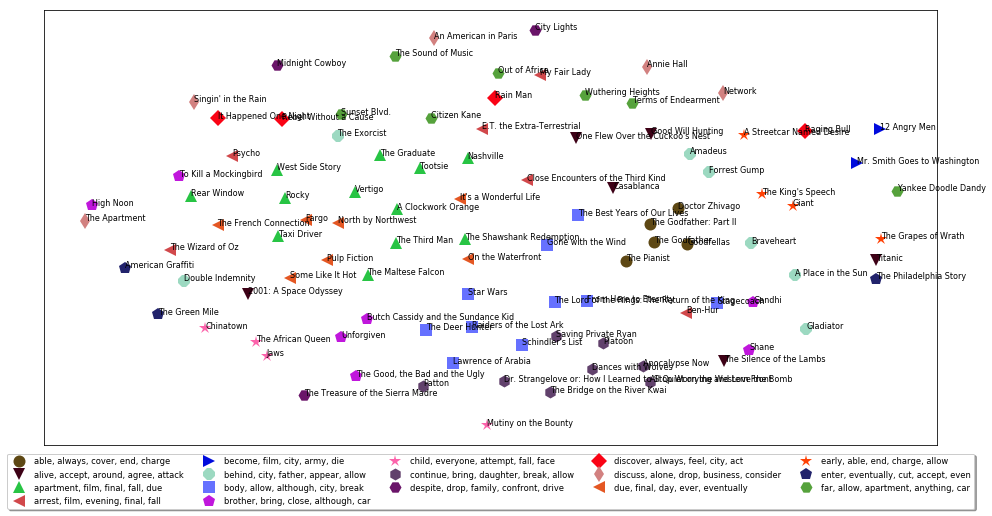

In [30]:
plot_clusters(num_clusters=num_clusters, 
              feature_matrix=feature_matrix,
              cluster_data=cluster_data, 
              movie_data=movie_data,
              plot_size=(16,8)) 

In [31]:
from scipy.cluster.hierarchy import ward, dendrogram

def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix
    
def plot_hierarchical_clusters(linkage_matrix, movie_data, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    movie_titles = movie_data['Title'].values.tolist()
    # plot dendrogram
    ax = dendrogram(linkage_matrix, orientation="left", labels=movie_titles)
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()
    plt.savefig('ward_hierachical_clusters.png', dpi=200)

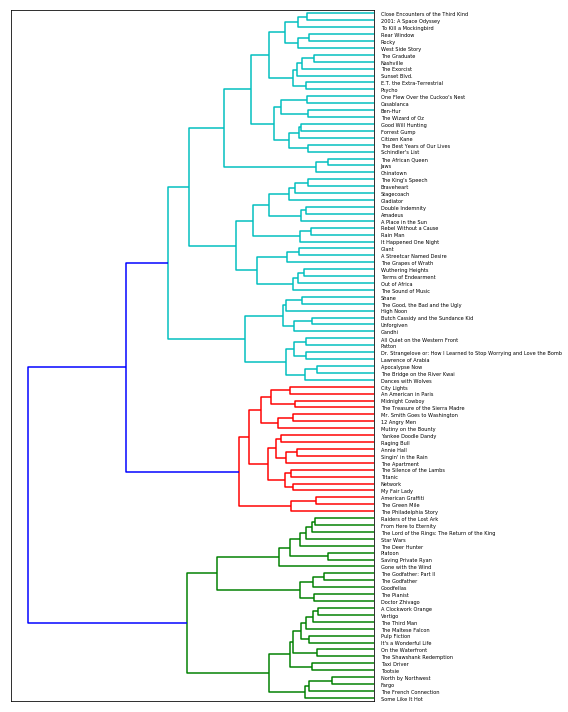

In [32]:
# build ward's linkage matrix    
linkage_matrix = ward_hierarchical_clustering(feature_matrix)
# plot the dendrogram
plot_hierarchical_clusters(linkage_matrix=linkage_matrix,
                           movie_data=movie_data,
                           figure_size=(8,10))

In [33]:
query_docs = ['The fox is definitely smarter than the dog',
            'Java is a static typed programming language unlike Python',
            'I love to relax under the beautiful blue sky!']

In [35]:
# normalize and extract features from the query corpus
norm_query_docs =  normalize_corpus(query_docs, lemmatize=True)            
query_docs_tfidf = vectorizer.transform(norm_query_docs)

In [36]:
def compute_cosine_similarity(doc_features, corpus_features,
                              top_n=3):
    # get document vectors
    doc_features = doc_features.toarray()[0]
    corpus_features = corpus_features.toarray()
    # compute similarities
    similarity = np.dot(doc_features, 
                        corpus_features.T)
    # get docs with highest similarity scores
    top_docs = similarity.argsort()[::-1][:top_n]
    top_docs_with_score = [(index, round(similarity[index], 3))
                            for index in top_docs]
    return top_docs_with_score

In [44]:
print ("Document Similarity Analysis using Cosine Similarity")
print ("="*60)
for index, doc in enumerate(query_docs):
    
    doc_tfidf = query_docs_tfidf[index]
    top_similar_docs = compute_cosine_similarity(doc_tfidf,
                                             feature_matrix,
                                             top_n=2)
    print ("Document",index+1 ,":", doc)
    print ("Top", len(top_similar_docs), "similar docs:")
    print ("-"*40 )
    for doc_index, sim_score in top_similar_docs:
        print ("Doc num: {} Similarity Score: {}\nDoc: {}".format(doc_index+1,
                                                                 sim_score,
                                                                 norm_movie_synopses[doc_index]))  
        print ("-"*40)       
    print    

Document Similarity Analysis using Cosine Similarity
Document 1 : The fox is definitely smarter than the dog
Top 2 similar docs:
----------------------------------------
Doc num: 100 Similarity Score: 0.0
Doc: film life renowned musical composer playwright actor dancer singer george cohan early day world war ii cohan retirement star president roosevelt rodgers hart musical would rather right first night summon meet president white house present congressional gold medal fact happened several year previously cohan overcome chat roosevelt recall early day stage film flash supposed birth july whilst father perform vaudeville stage cohan sister family act soon learn dance soon cohan perform successfully george cocky grow blacklist theatrical producer troublesome leave act hawk song unsuccessfully around producer partnership another struggle writer sam harris finally interest producer road success marry mary young singer dancer star ascends persuade struggle parent act eventually vest valuab

In [46]:
def compute_hellinger_bhattacharya_distance(doc_features, corpus_features,
                                            top_n=3):
    # get document vectors                                            
    doc_features = doc_features.toarray()[0]
    corpus_features = corpus_features.toarray()
    # compute hb distances
    distance = np.hstack(
                    np.sqrt(0.5 *
                            np.sum(
                                np.square(np.sqrt(doc_features) - 
                                          np.sqrt(corpus_features)), 
                                axis=1)))
    # get docs with lowest distance scores                            
    top_docs = distance.argsort()[:top_n]
    top_docs_with_score = [(index, round(distance[index], 3))
                            for index in top_docs]
    return top_docs_with_score 

print ("Document Similarity Analysis using Hellinger-Bhattacharya distance")
print ("="*60)
for index, doc in enumerate(query_docs):
    
    doc_tfidf = query_docs_tfidf[index]
    top_similar_docs = compute_hellinger_bhattacharya_distance(doc_tfidf,
                                             feature_matrix,
                                             top_n=2)
    print ("Document",index+1 ,":", doc)
    print ("Top", len(top_similar_docs), "similar docs:")
    print ("-"*40) 
    for doc_index, sim_score in top_similar_docs:
        print ("Doc num: {} Distance Score: {}\nDoc: {}".format(doc_index+1,
                                                                 sim_score,
                                                                 norm_movie_synopses[doc_index]))  
        print ("-"*40)
    print

Document Similarity Analysis using Hellinger-Bhattacharya distance
Document 1 : The fox is definitely smarter than the dog
Top 2 similar docs:
----------------------------------------
Doc num: 44 Distance Score: 1.575
Doc: jerry mulligan gene kelly exuberant american expatriate paris reputation painter friend adam oscar levant struggle concert pianist long time associate french singer henri baurel george guetary lonely society woman milo robert nina foch take jerry wing support interested jerry art jerry remain oblivious feeling fall love lise leslie caron french girl meet restaurant lise love well already relationship henri feel indebted save family world war ii raucous masked ball everyone black white costume milo learn jerry interested jerry learn lise love marry henri next day henri overhear conversation henri drive lise away jerry daydream paris reverie break car horn sound henri bring lise
----------------------------------------
Doc num: 65 Distance Score: 1.581
Doc: chaplin cit

In [47]:
import scipy.sparse as sp 

def compute_corpus_term_idfs(corpus_features, norm_corpus):
    
    dfs = np.diff(sp.csc_matrix(corpus_features, copy=True).indptr)
    dfs = 1 + dfs # to smoothen idf later
    total_docs = 1 + len(norm_corpus)
    idfs = 1.0 + np.log(float(total_docs) / dfs)
    return idfs


def compute_bm25_similarity(doc_features, corpus_features,
                            corpus_doc_lengths, avg_doc_length,
                            term_idfs, k1=1.5, b=0.75, top_n=3):
    # get corpus bag of words features
    corpus_features = corpus_features.toarray()
    # convert query document features to binary features
    # this is to keep a note of which terms exist per document
    doc_features = doc_features.toarray()[0]
    doc_features[doc_features >= 1] = 1
    
    # compute the document idf scores for present terms
    doc_idfs = doc_features * term_idfs
    # compute numerator expression in BM25 equation
    numerator_coeff = corpus_features * (k1 + 1)
    numerator = np.multiply(doc_idfs, numerator_coeff)
    # compute denominator expression in BM25 equation
    denominator_coeff =  k1 * (1 - b + 
                                (b * (corpus_doc_lengths / 
                                        avg_doc_length)))
    denominator_coeff = np.vstack(denominator_coeff)
    denominator = corpus_features + denominator_coeff
    # compute the BM25 score combining the above equations
    bm25_scores = np.sum(np.divide(numerator,
                                   denominator),
                         axis=1)
    # get top n relevant docs with highest BM25 score                     
    top_docs = bm25_scores.argsort()[::-1][:top_n]
    top_docs_with_score = [(index, round(bm25_scores[index], 3))
                            for index in top_docs]
    return top_docs_with_score

In [50]:
vectorizer1, corpus_features1 = build_feature_matrix(norm_movie_synopses,
                                                   feature_type='frequency')
query_docs_features = vectorizer1.transform(norm_query_docs)

doc_lengths = [len(doc.split()) for doc in norm_movie_synopses]   
avg_dl = np.average(doc_lengths) 
corpus_term_idfs = compute_corpus_term_idfs(corpus_features1,
                                            norm_movie_synopses)
                 
print ("Document Similarity Analysis using BM25")
print ("="*60)
for index, doc in enumerate(query_docs):
    
    doc_features = query_docs_features[index]
    top_similar_docs = compute_bm25_similarity(doc_features,
                                               corpus_features1,
                                               doc_lengths,
                                               avg_dl,
                                               corpus_term_idfs,
                                               k1=1.5, b=0.75,
                                               top_n=2)
    print ("Document",index+1 ,":", doc)
    print ("Top", len(top_similar_docs), "similar docs:")
    print ("-"*40) 
    for doc_index, sim_score in top_similar_docs:
        print ("Doc num: {} BM25 Score: {}\nDoc: {}".format(doc_index+1,
                                                                 sim_score,
                                                                 norm_movie_synopses[doc_index]))  
        print ("-"*40)       
    print

Document Similarity Analysis using BM25
Document 1 : The fox is definitely smarter than the dog
Top 2 similar docs:
----------------------------------------
Doc num: 4 BM25 Score: 6.091
Doc: film open old fat jake lamotta robert de niro practice stand comic routine debut comedy nightclub flashback shift boxing career opponent jimmy reef infamous cleveland bout lose fight fixed result cause fight break end match jakes brother joey lamotta joe pesci spar partner responsible organize fights joey discuss potential shot title mob connection salvy batts frank vincent way brother house neighborhood bronx finally settle house jake admit much faith ability accompany brother local open air swimming pool restless jake spot year old girl name vickie cathy moriarty edge pool although remind brother already marry opportunity invite day soon true joey give jake fight sugar ray robinson set year apart jake lose second judge rule favor sugar ray leave sport temporarily conscription united state army de